In [20]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
EXPERIMENT_NAME = 'Linear'

## Set configuration

In [28]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg

#Set model specific config
cfg.enc_hidden_dim = [cfg.obs_dim, 40, 70, cfg.factor_dim]
cfg.dec_hidden_dim = [cfg.factor_dim, cfg.obs_dim]
cfg.enc_activation = nn.Tanh
cfg.dec_activation = nn.Identity
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = False

#set experiment specifig training params
cfg.lr = 0.005
cfg.max_iter = 50

## Obtain Data
Obtain the simulated $y$ and $f$

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=70, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=70, out_features=100, bias=True)
    (activation_2): Tanh()
  )
)
(4096, 100) (512, 100) (2048, 100)


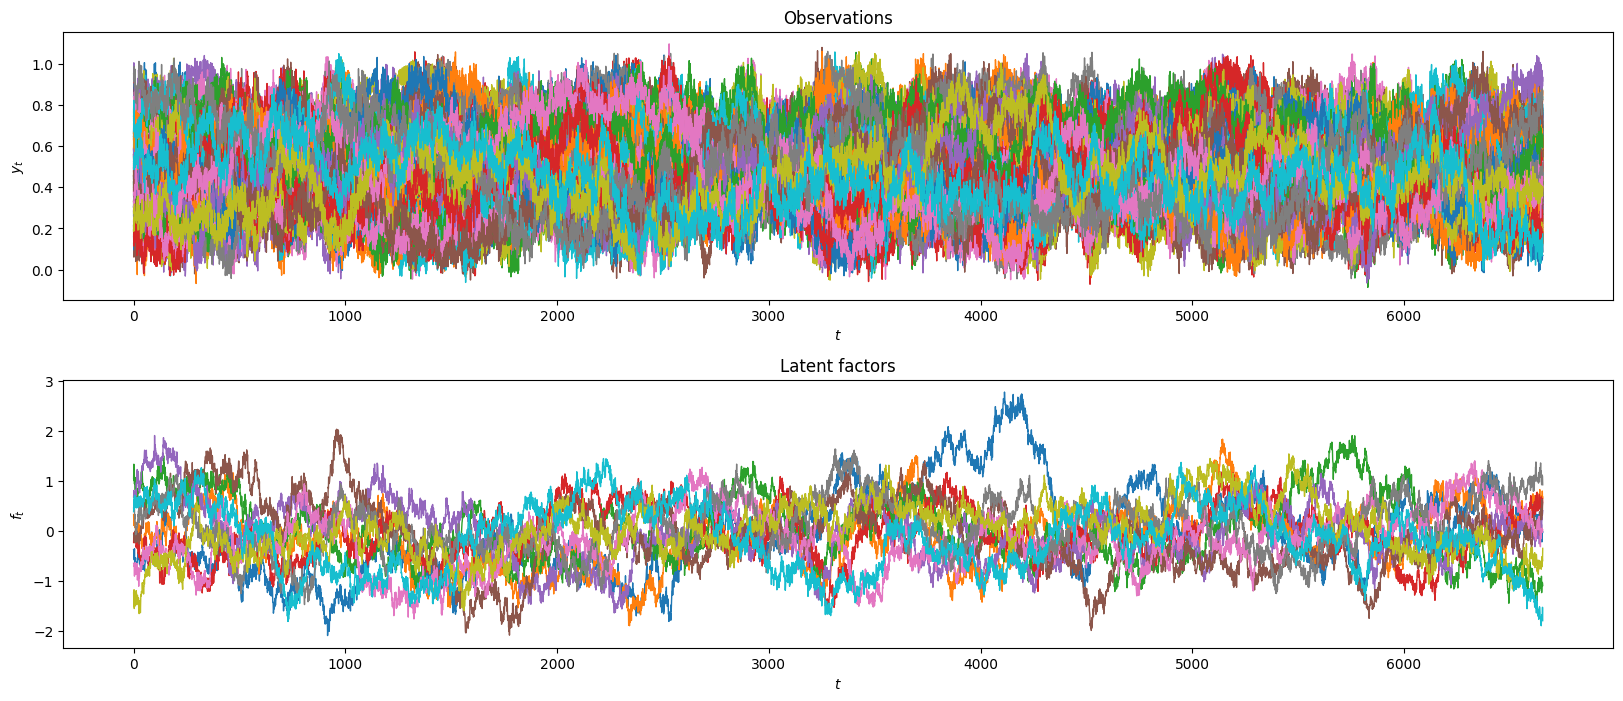

In [29]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [5]:
#torch.save(dec, '../DGP/saved/dec_2.pt')
#np.save(arr=y, file='../DGP/saved/y_2.npy')
#np.save(arr=f, file='../DGP/saved/f_2.npy')

## Estimate autoencoder model

In [30]:
dec = Decoder(hidden_dim=cfg.dec_hidden_dim, activation=cfg.dec_activation, lastLayerLinear=cfg.dec_last_layer_linear)
enc = Encoder(hidden_dim=cfg.enc_hidden_dim, activation=cfg.enc_activation, lastLayerLinear=cfg.enc_last_layer_linear)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]

train_hist = trainMCMC(X_train=y_train, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter = cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")


Number of trainable paramaters 2110
torch.Size([4096, 100]) torch.Size([512, 100])
1 0.9129735752940178752940178
2 0.017603836022317416022317414
3 0.009444314171560109171560109
4 0.006816646957304329957304329
5 0.0056399532477371395477371395
6 0.0051092900102958080102958086
7 0.0046267582220025362220025366
8 0.0040366328321397305321397305
9 0.0035757576406467706406467706
10 0.003193188342265784722657847
11 0.003026618738658726386587263
12 0.002929974230937659709376597
13 0.002897534257499501574995016
14 0.002893262833822518638225186
15 0.002868729934561997745619977
16 0.002865840273443609534436095
17 0.002857758576283231462832314
18 0.002831436169799417397994173
19 0.002831078134477138544771385
20 0.002805044670822099708220993
21 0.002783031290164217401642174
22 0.002795873500872403408724034
23 0.002754764776909724769097247
24 0.002790929953334853533348535
25 0.002675945725059136750591367
26 0.002652247902005911020059118
27 0.002616177604068070740680707
28 0.002569066040450707404507073

In [7]:
logResults(train_hist, mod, cfg, EXPERIMENT_NAME)

./Results/2/3_Linear_05092023_22:25:20


### Train & val loss

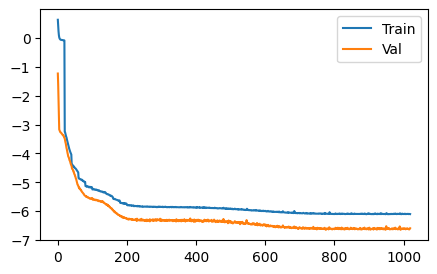

In [31]:
plot_train_hist(train_hist, log=True)

### Convergence of mu of epsilon

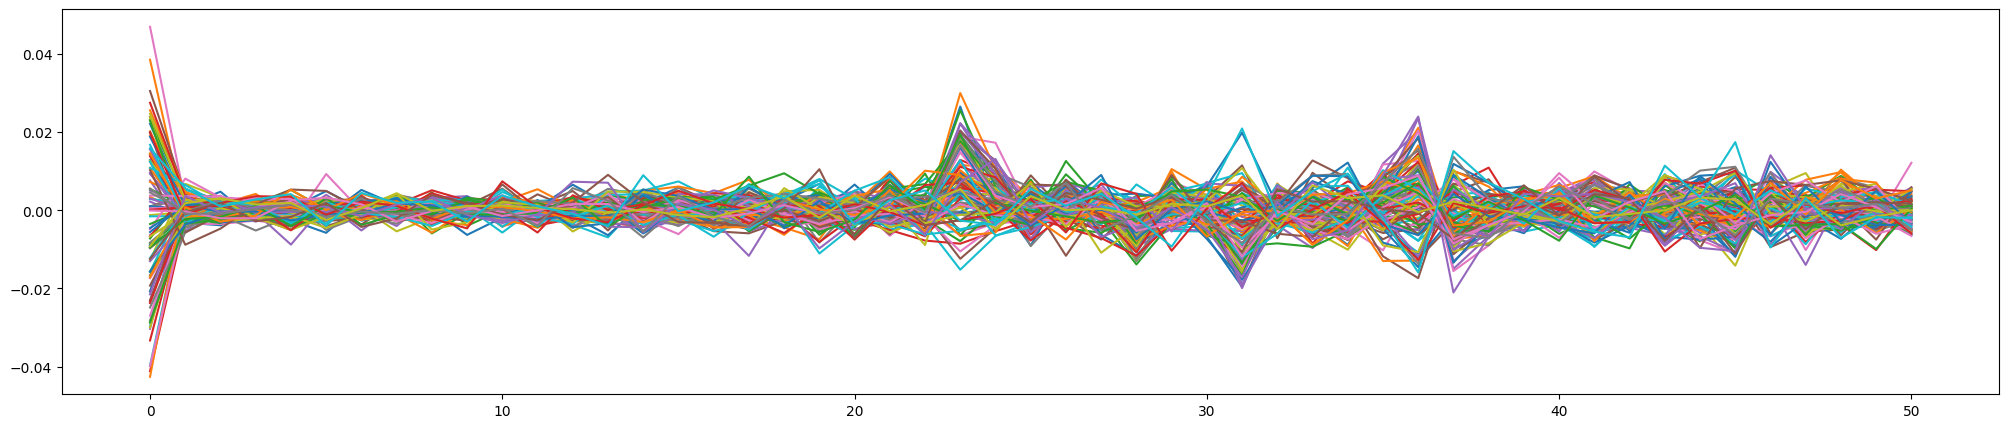

In [32]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

### Reconstruction of y

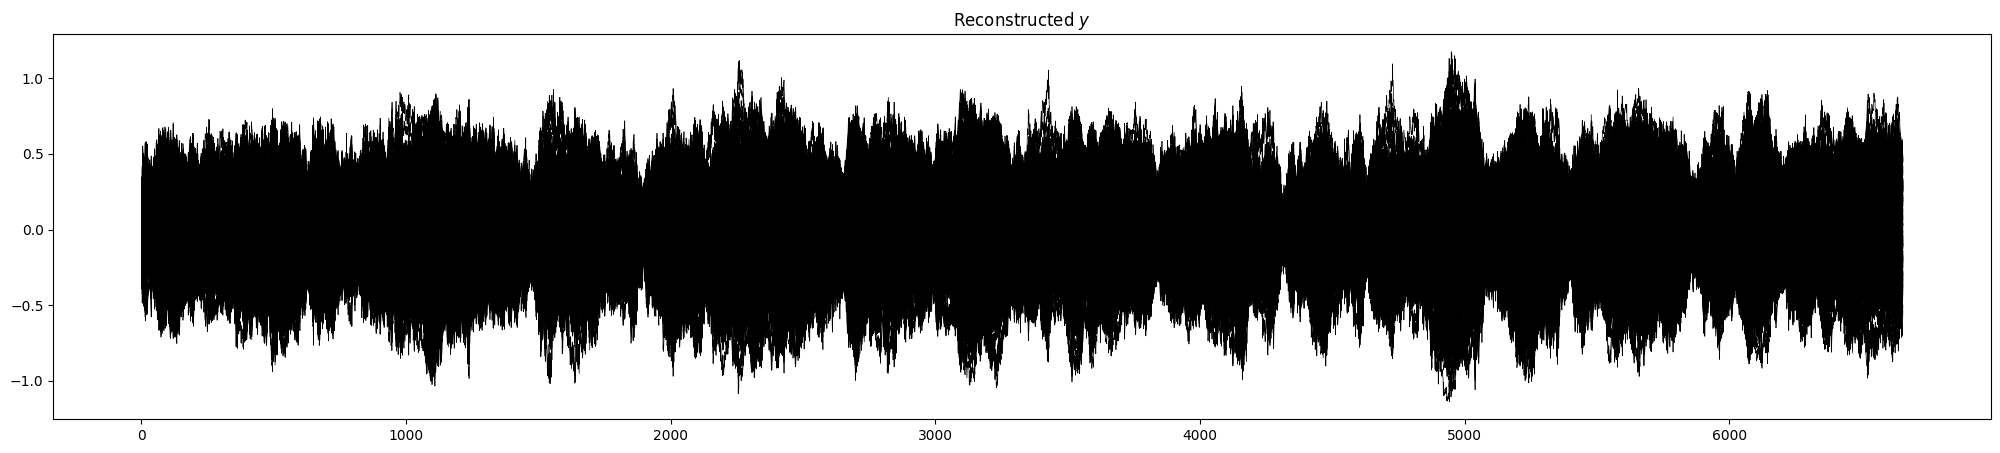

In [10]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


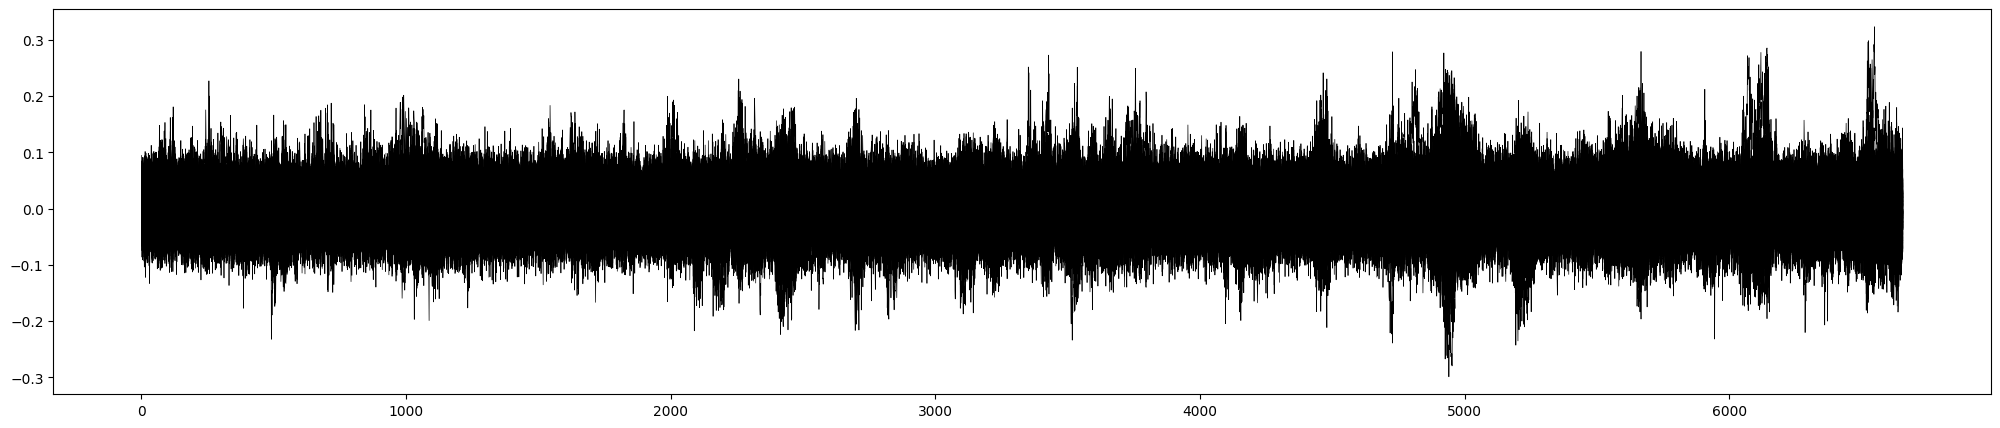

In [11]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

### Factor estimation

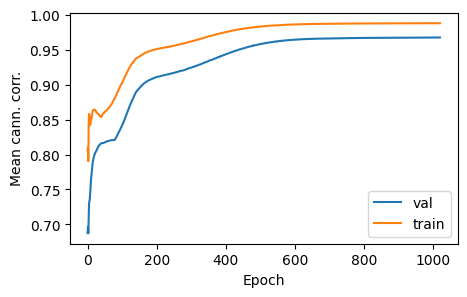

In [33]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'], label='val')
plt.plot(train_hist['train_CCA_mean_corr'], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

In [34]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.9880752847992088
cc on test data: 0.9857515268534902


/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


cc on train data:  0.988075059752868


/Users/julianvanmeggelen/Library/Python/3.9/lib/python/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


cc on test data:  0.9857513820271713


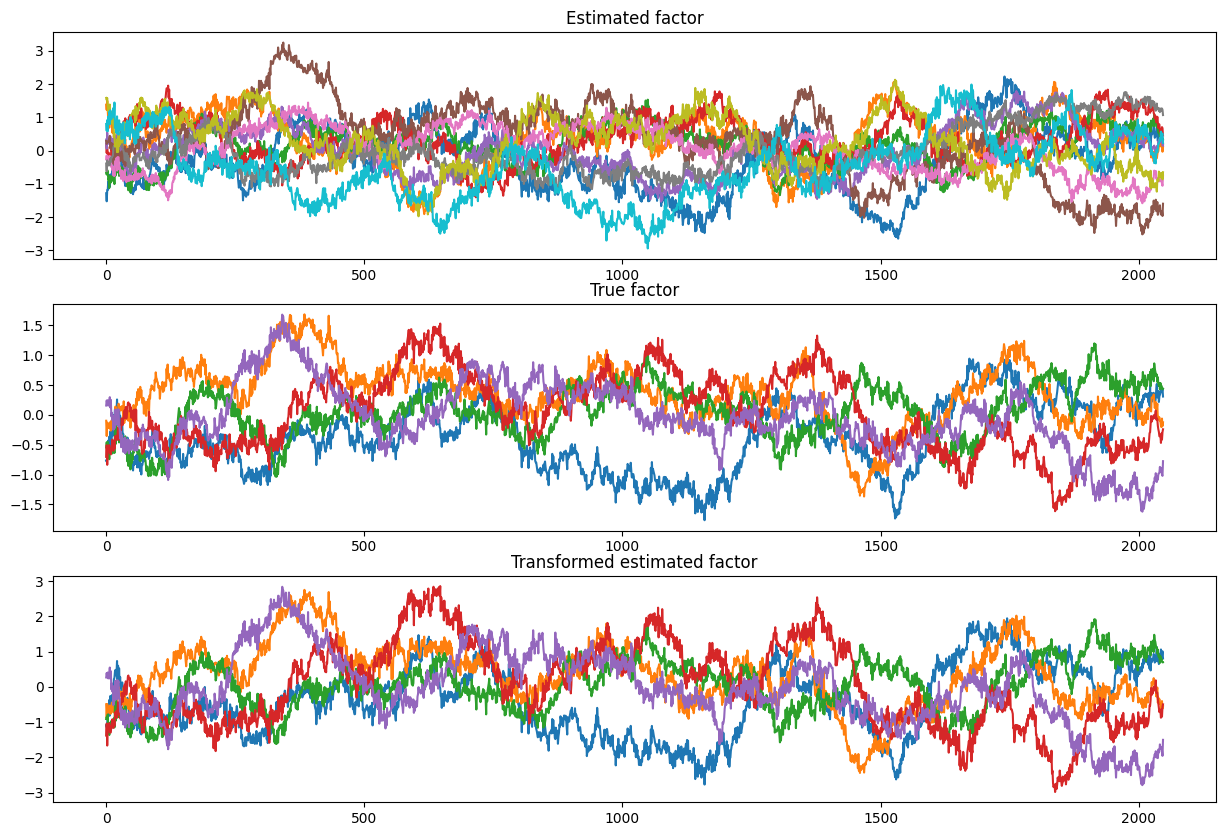

In [14]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

### Forecast

1-step ahead  FMSE on the test set: 0.004436733201146126


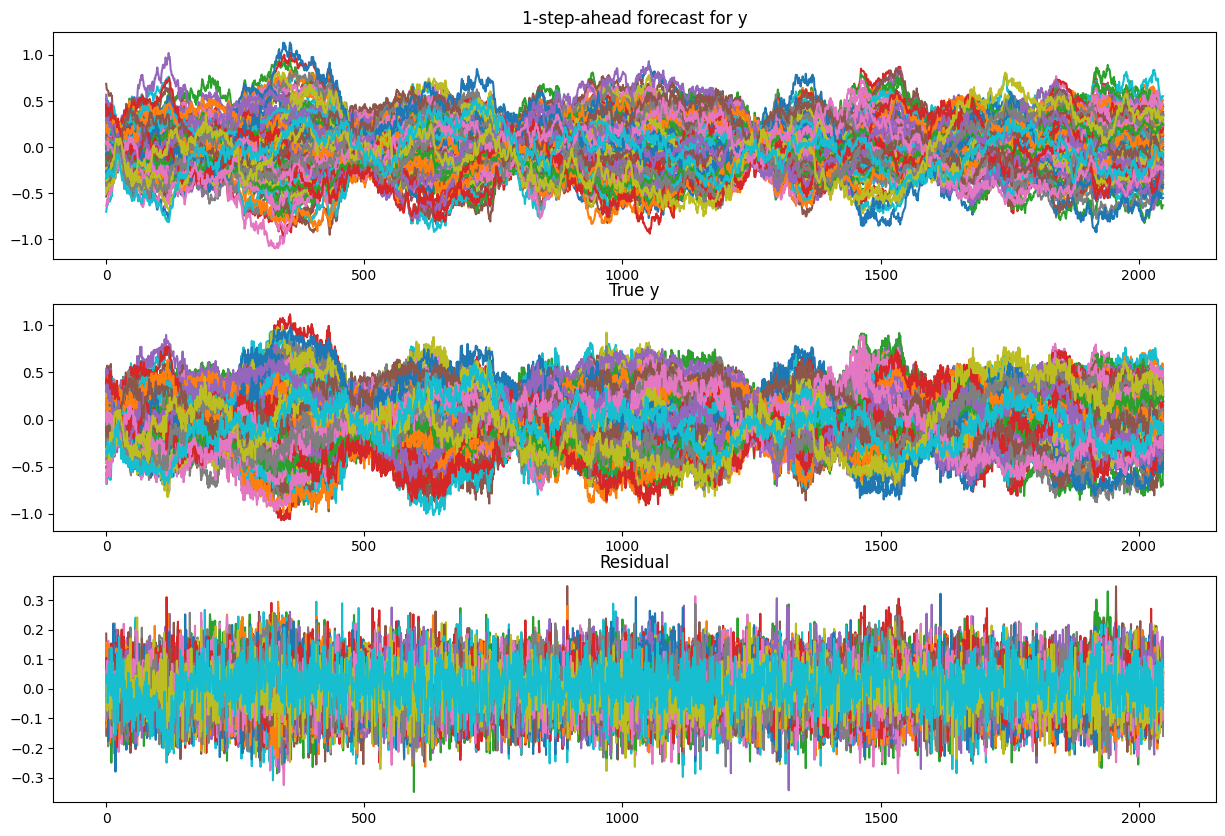

In [15]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")